In [1]:
import sys
sys.path.append('../')
import torch
from fit.datamodules.super_res import MNIST_SResFITDM, CelebA_SResFITDM,BioSRMicrotubules,BioSRFActin
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule
import os
from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.utils.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch
from torch.nn.functional import interpolate
import numpy as np
from pytorch_lightning import seed_everything
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from fit.utils.utils import denormalize

# trained_model_path= '/group/jug/Aman/Trained_Models/MNIST/fast/sum/Fast_MNIST_wp_1000_sum_L_8_H_8_s_10_subset_False_30-05_11-52-23/'
# checkpoints = os.listdir(trained_model_path)
# checkpoints.remove('last.ckpt')
# checkpoints.remove('wandb')
# trained_model_path = trained_model_path + checkpoints[3]


# trained_model_path = '/group/jug/Aman/Trained_Models/CelebA/mamba/sum/Mamba_CelebA_wp_1000_sum_L_8_H_8_s_10_subset_False_SectorEncoder_NSec10_01-06_16-12-07/epoch=600-step=375625.ckpt'
# n_heads = 8
# n_layers = 8
# d_query = 32

trained_model_path = '/group/jug/Aman/Trained_Models/CelebA/mamba/sum/Mamba_CelebA_wp_1000_sum_L_12_H_12_s_5_subset_False_SectorEncoder_NSec10_16-06_19-57-36/epoch=183-step=57592.ckpt'
n_heads = 12
n_layers = 12
d_query = 64


print(trained_model_path)
dataset = trained_model_path.split('/')[-5]
model_type = trained_model_path.split('/')[-4]
loss = trained_model_path.split('/')[-3]
# dataset = "MNIST"
# model_type = 'mamba'
# loss = 'sum'

seed_everything(22122020)

if dataset == "MNIST":
    dm = MNIST_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=1024, subset_flag=False)
if dataset == "CelebA":
    dm = CelebA_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=8, subset_flag=False)
if dataset == "Bio":
    dm = BioSRFActin('./', 8)
dm.prepare_data()
dm.setup()
r, phi, flatten_order, order, fc_per_ring = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)

model = SResTransformerModule(img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss=loss,
                              w_phi = 1000,
                              lr=0.0001, weight_decay=0.01, n_layers=n_layers,
                              n_heads=n_heads, d_query=d_query,num_shells = 12,
                              no_of_sectors=10,
                              model_type = model_type,
                              fc_per_ring=fc_per_ring).cuda()

print("model initialized")

if 1:
    weights = torch.load(trained_model_path)['state_dict']
    model.load_state_dict(weights, strict=False)
    model.cuda()
    model.eval()
    print('Trained Model Loaded Successfully !!!')
else:
    print('Model not loaded, Randomly initialized')

/localscratch/miniforge3/envs/SSM_LS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 22122020


/group/jug/Aman/Trained_Models/CelebA/mamba/sum/Mamba_CelebA_wp_1000_sum_L_12_H_12_s_5_subset_False_SectorEncoder_NSec10_16-06_19-57-36/epoch=183-step=57592.ckpt
model initialized
Trained Model Loaded Successfully !!!


In [2]:
lowres_total = []
pred_total = []
gt_total = []
dn_lowres_total = []
dn_pred_total = []
dn_gt_total = []
i = 0

for fc, (mag_min, mag_max) in tqdm(dm.train_dataloader()):
    fc = fc.to('cuda')
    fc = fc[:,model.dst_flatten_order]
    mag_max = mag_max.to('cuda')
    mag_min = mag_min.to('cuda')
    x_input = fc[:,:model.input_seq_length]
    
    with torch.no_grad():
        pred = model.sres.forward_i(x_input)
        
        fc_loss, amp_loss, phi_loss,weighted_phi_loss = model.criterion(pred, fc, mag_min, mag_max)
        
        print(f'fc_loss: {fc_loss}, amp_loss: {amp_loss}, phi_loss: {phi_loss}, weighted_phi_loss: {weighted_phi_loss}')
    
    lowres_img = model.convert2img(fc=x_input, mag_min=mag_min, mag_max=mag_max)
    
    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)
    
    gt_img = model.convert2img(fc=fc, mag_min=mag_min, mag_max=mag_max)

    lowres_img_denormed = denormalize(lowres_img,
                                          dm.mean,
                                          dm.std)
    pred_img_denormed = denormalize(pred_img, dm.mean,
                                        dm.std)
    gt_img_denormed = denormalize(gt_img, dm.mean,
                                      dm.std)
    
    lr_pr_dn = PSNR(gt_img_denormed, lowres_img_denormed)
    pr_dn = PSNR(gt_img_denormed, pred_img_denormed)
    gt_dn = PSNR(gt_img_denormed, gt_img_denormed)
    
    
    lowres_psnr = PSNR(gt_img, lowres_img)
    pred_psnr = PSNR(gt_img, pred_img)
    gt_psnr = PSNR(gt_img, gt_img)

    lowres_total.append(lowres_psnr)
    pred_total.append(pred_psnr)
    gt_total.append(gt_psnr)
    dn_lowres_total.append(lr_pr_dn)
    dn_pred_total.append(pr_dn)
    dn_gt_total.append(gt_dn)
    break

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:10<?, ?it/s]

fc_loss: 1093.2926025390625, amp_loss: 186.84527587890625, phi_loss: 0.9064474105834961, weighted_phi_loss: 906.4473876953125


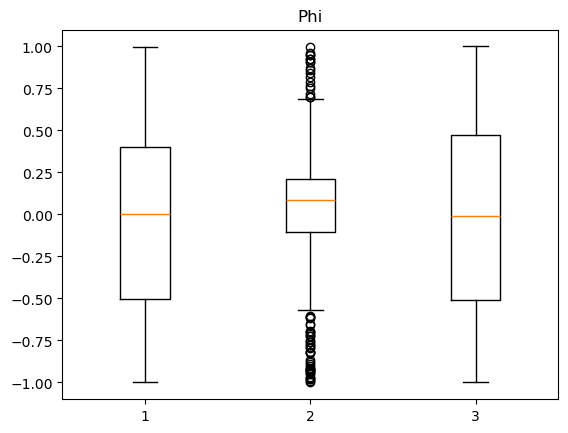

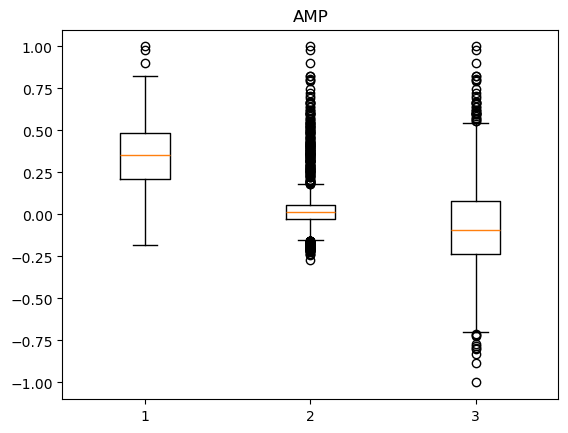

In [3]:
plt.boxplot([x_input[0,:,1].cpu(),pred[0,:,1].cpu(), fc[0,:,1].cpu()]);plt.title('Phi');plt.show()
plt.boxplot([x_input[0,:,0].cpu(),pred[0,:,0].cpu(), fc[0,:,0].cpu()]);plt.title('AMP');plt.show()

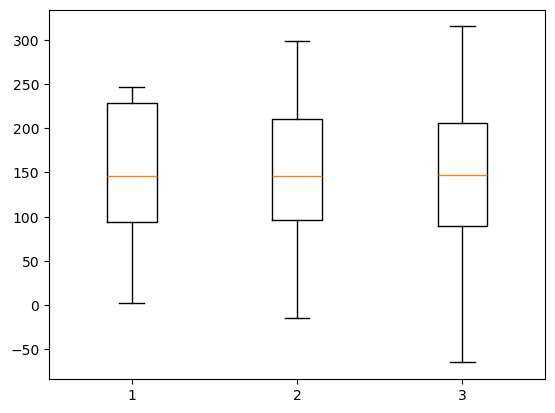

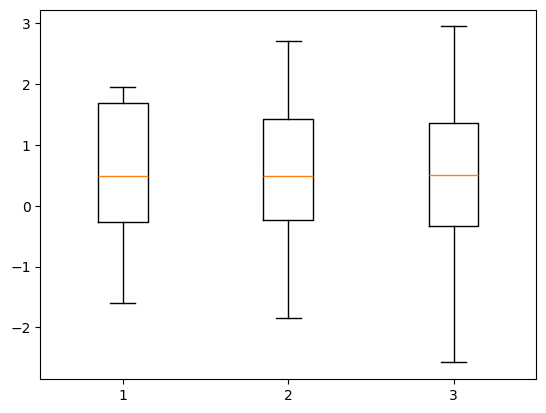

In [89]:


plt.boxplot([gt_img_denormed[0].cpu().flatten(),lowres_img_denormed[0].cpu().flatten(), pred_img_denormed[0].cpu().flatten()]);plt.show()
plt.boxplot([gt_img[0].cpu().flatten(),lowres_img[0].cpu().flatten(), pred_img[0].cpu().flatten()]); plt.show()


In [ ]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization


tensor(-20.9562, device='cuda:0')

In [73]:
loss_fn_alex.cuda()
loss_fn_vgg.cuda()
print("LOWER IS BETTER \n",
      "ALEX:",
      loss_fn_alex(lowres_img[0], gt_img[0]).item(),
      "--->",
      loss_fn_alex(pred_img[0], gt_img[0]).item(),
      "\n",
      "VGG:",
loss_fn_vgg(lowres_img[0], gt_img[0]).item(),

loss_fn_vgg(pred_img[0], gt_img[0]).item())



LOWER IS BETTER 
 ALEX: 0.6767534017562866 ---> 0.5978348255157471 
 VGG: 0.6029313206672668 0.6993584036827087


In [74]:
loss_fn_alex.cuda()
loss_fn_vgg.cuda()
print(loss_fn_alex(lowres_img_denormed[0], gt_img_denormed[0]).item(),
      "--->",
      loss_fn_alex(pred_img_denormed[0], gt_img_denormed[0]).item(),
      "\n",
loss_fn_vgg(lowres_img_denormed[0], gt_img_denormed[0]).item(),
"--->",
loss_fn_vgg(pred_img[0], gt_img_denormed[0]).item())



0.4407229721546173 ---> 0.4097190499305725 
 0.27871817350387573 ---> 0.6480708718299866


In [77]:
gt_img.max(), gt_img.min(), lowres_img.max(), lowres_img.min(), pred_img.max(), pred_img.min())
print(gt_img_denormed.max(), gt_img_denormed.min(), lowres_img_denormed.max(), lowres_img_denormed.min(), pred_img_denormed.max(), pred_img_denormed.min())

tensor(2.0540, device='cuda:0') tensor(-1.6348, device='cuda:0') tensor(2.6462, device='cuda:0') tensor(-2.4472, device='cuda:0') tensor(5.5905, device='cuda:0') tensor(-5.6001, device='cuda:0')
tensor(253.5108, device='cuda:0') tensor(0., device='cuda:0') tensor(294.2131, device='cuda:0') tensor(-55.8333, device='cuda:0') tensor(496.5601, device='cuda:0') tensor(-272.5172, device='cuda:0')


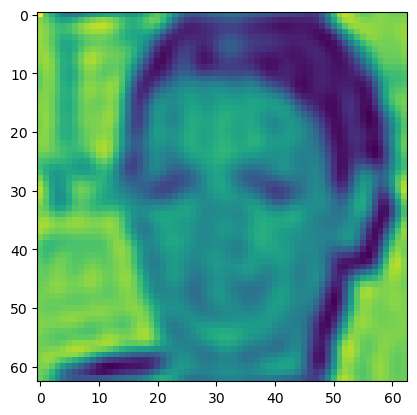

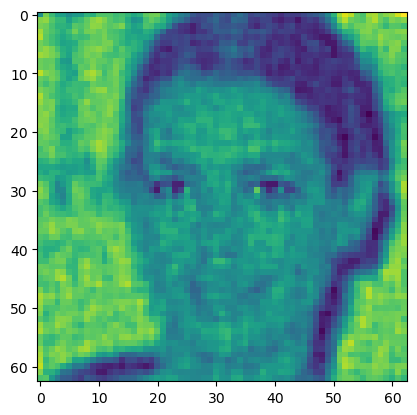

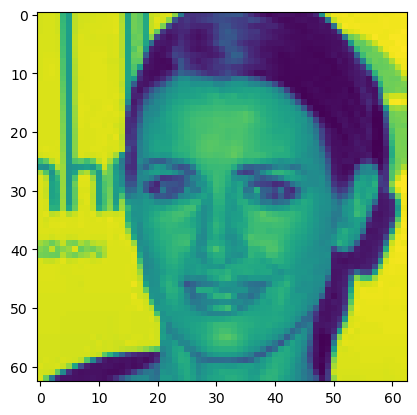

In [12]:
lowres_psnr[0], pred_psnr[0], gt_psnr[0]

(tensor(22.1520, device='cuda:0'),
 tensor(20.7262, device='cuda:0'),
 tensor(171.0732, device='cuda:0'))

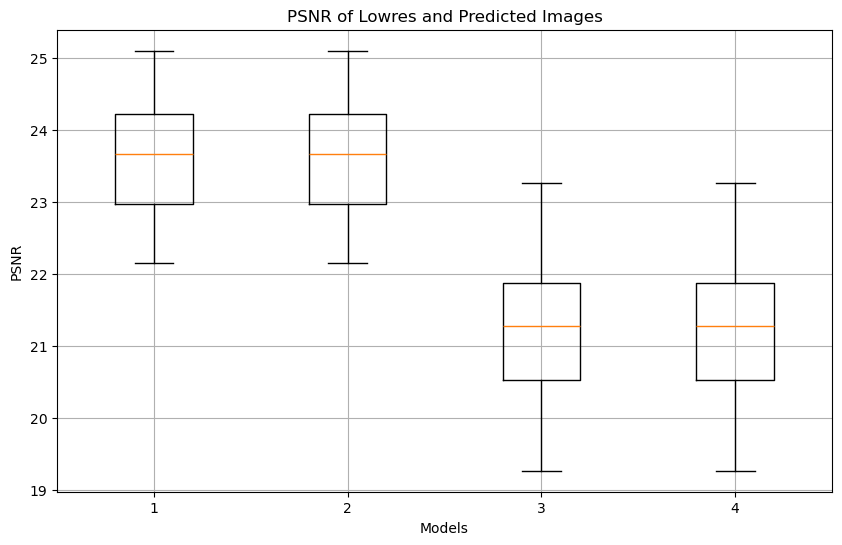

In [91]:
lowres_all = torch.cat(dn_lowres_total)
psnr_all = torch.cat(dn_pred_total)
lowres_all_2 = torch.cat(lowres_total)
psnr_all_2 = torch.cat(pred_total)

# lr = torch.load('/group/jug/Aman/Inference/mamba/10-55-04/sum/CelebA/5/05_06-18_59_49/mamba_lowres.pt')
# a = torch.load('/group/jug/Aman/Inference/fast/18-32-39/sum/CelebA/5/05_06-19_15_24/fast_pred.pt')
# b = torch.load('/group/jug/Aman/Inference/mamba/10-55-04/sum/CelebA/5/05_06-18_59_49/mamba_pred.pt')|
# c = torch.load('./MNIST_fast_pred.pt')
# d = torch.load('./CelebA_mamba_pred_new_5rings.pt')


fig, ax = plt.subplots(figsize=(10, 6))


# ax.boxplot([lowres_all.cpu().numpy(),a.cpu().numpy(),b.cpu().numpy(),d.cpu().numpy()], widths= 0.4, labels = ['Lowres','Transformers\nOriginal Encoding','Mamba\nOriginal Encoding','Mamba\nNew Encoding']);
ax.boxplot([lowres_all.cpu().numpy(),lowres_all_2.cpu(),psnr_all.cpu().numpy(),psnr_all_2.cpu()], widths= 0.4)
ax.set_xlabel("Models")
ax.set_ylabel("PSNR")
ax.grid()
ax.title.set_text(f"PSNR of Lowres and Predicted Images")


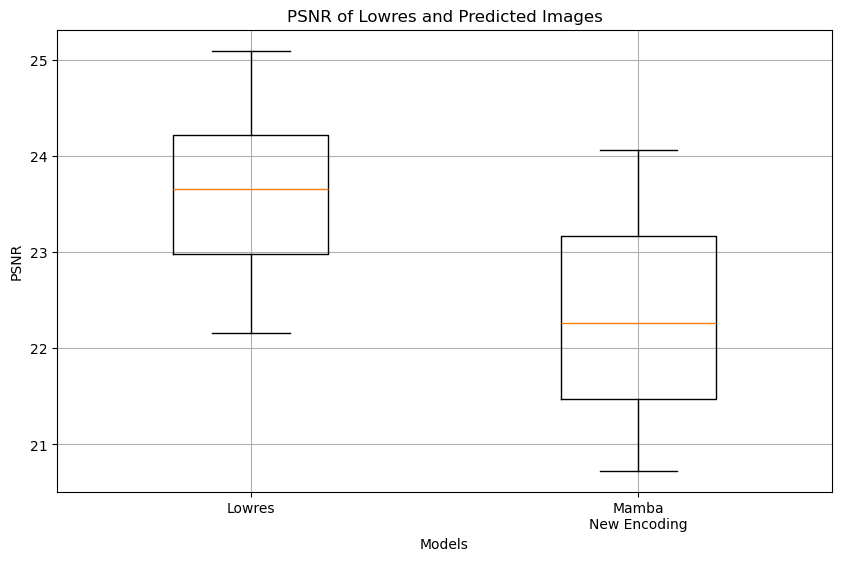

In [ ]:
a = torch.load('/home/aman.kukde/Projects/FourierImageTransformer/inference_results/inference_results_mamba/mamba_lowres.pt')
b = torch.load('/home/aman.kukde/Projects/FourierImageTransformer/inference_results/inference_results_mamba/mamba_pred.pt')

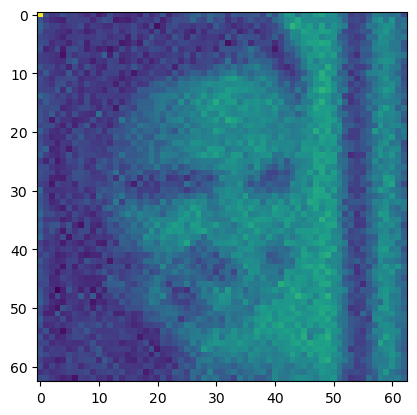

In [ ]:
plt.imshow(model.convert2img(pred,mag_min,mag_max)[4].cpu().numpy())

In [ ]:
for fc, (mag_min, mag_max) in dm.test_dataloader():
        break

fc = fc.to('cuda')
mag_min = mag_min.to('cuda')
mag_max = mag_max.to('cuda')
fc = fc[:, model.dst_flatten_order]
x_input = fc.clone()

with torch.no_grad():
    pred = model.sres.forward_i(x_input)
    fc_loss, amp_loss, phi_loss,weighted_phi_loss = model.criterion(pred, fc, mag_min, mag_max)
    print(f'fc_loss: {fc_loss}, amp_loss: {amp_loss}, phi_loss: {phi_loss}, weighted_phi_loss: {weighted_phi_loss}')
fig = plt.figure()
lowres = x_input.clone()
lowres[:, model.input_seq_length:] = fc.min()
# lowres[:] = 0
pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)
lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
gt_img = model.convert2img(fc=fc, mag_min=mag_min, mag_max=mag_max)


x_input: torch.Size([8, 2016, 2])---> lr_shape: torch.Size([8, 11, 110, 2])
fc_loss: 16484.650390625, amp_loss: 15569.779296875, phi_loss: 0.9148703813552856, weighted_phi_loss: 914.870361328125


<Figure size 640x480 with 0 Axes>

In [1]:
plt.imshow(gt_img[4].cpu().numpy(), cmap = 'gray');plt.show()
plt.imshow(lowres_img[4].cpu().numpy(), cmap = 'gray');plt.show()
plt.imshow(pred_img[4].cpu().numpy(), cmap = 'gray');plt.show()

NameError: name 'plt' is not defined

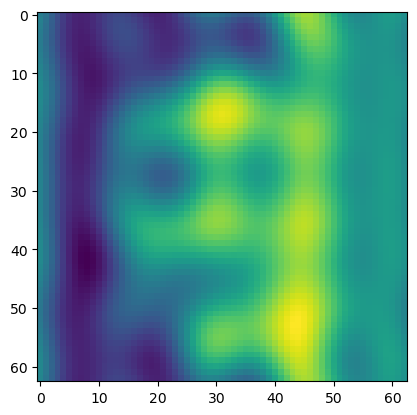

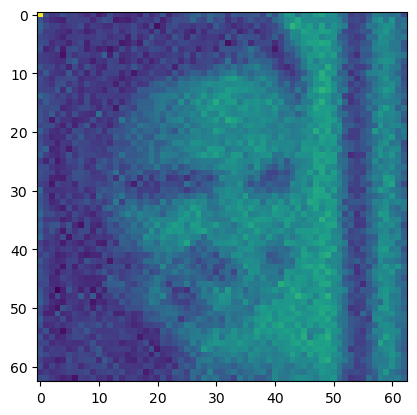

In [ ]:
plt.imshow(lowres_img[4].cpu().numpy());plt.show()
plt.imshow(pred_img[4].cpu().numpy())

fc_loss: 929.2499389648438, amp_loss: 63.420406341552734, phi_loss: 0.8658295273780823, weighted_phi_loss: 865.8295288085938


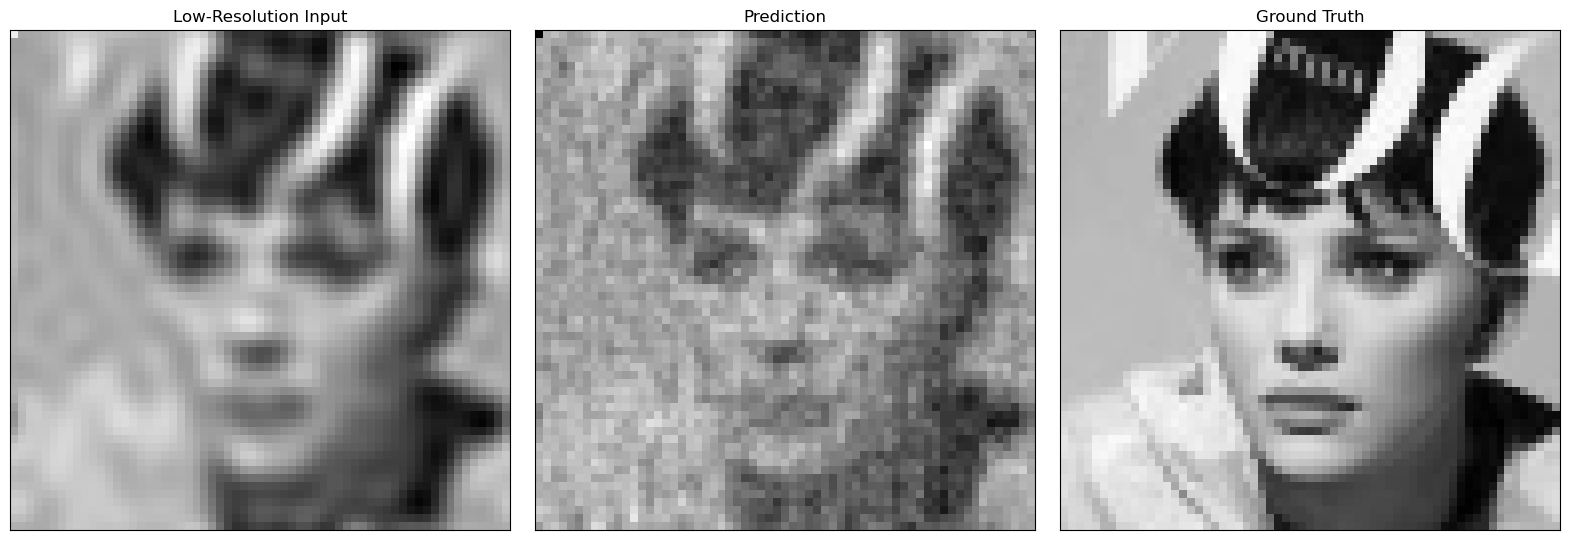

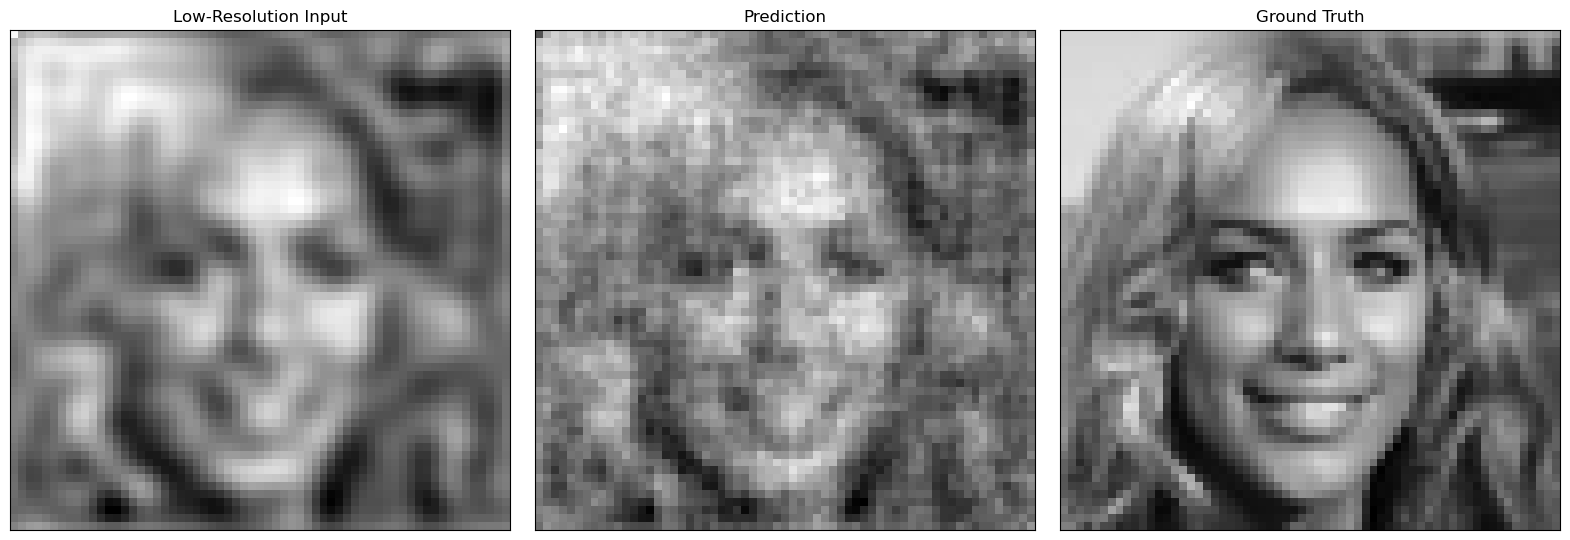

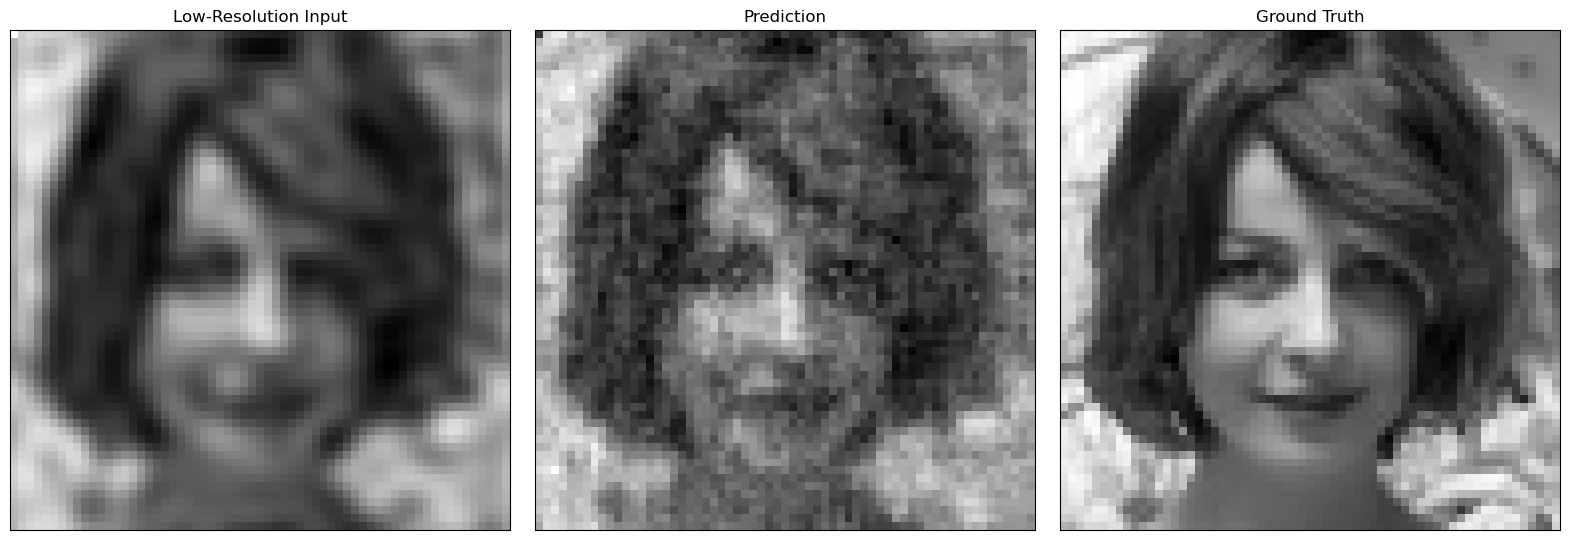

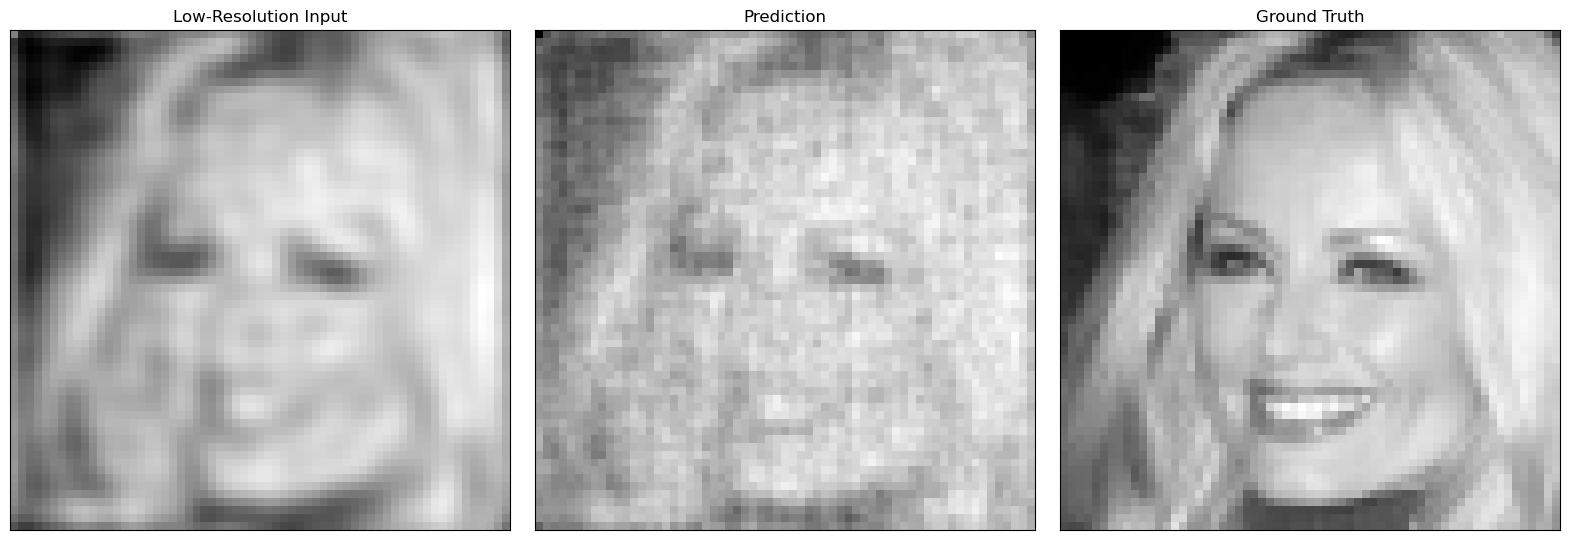

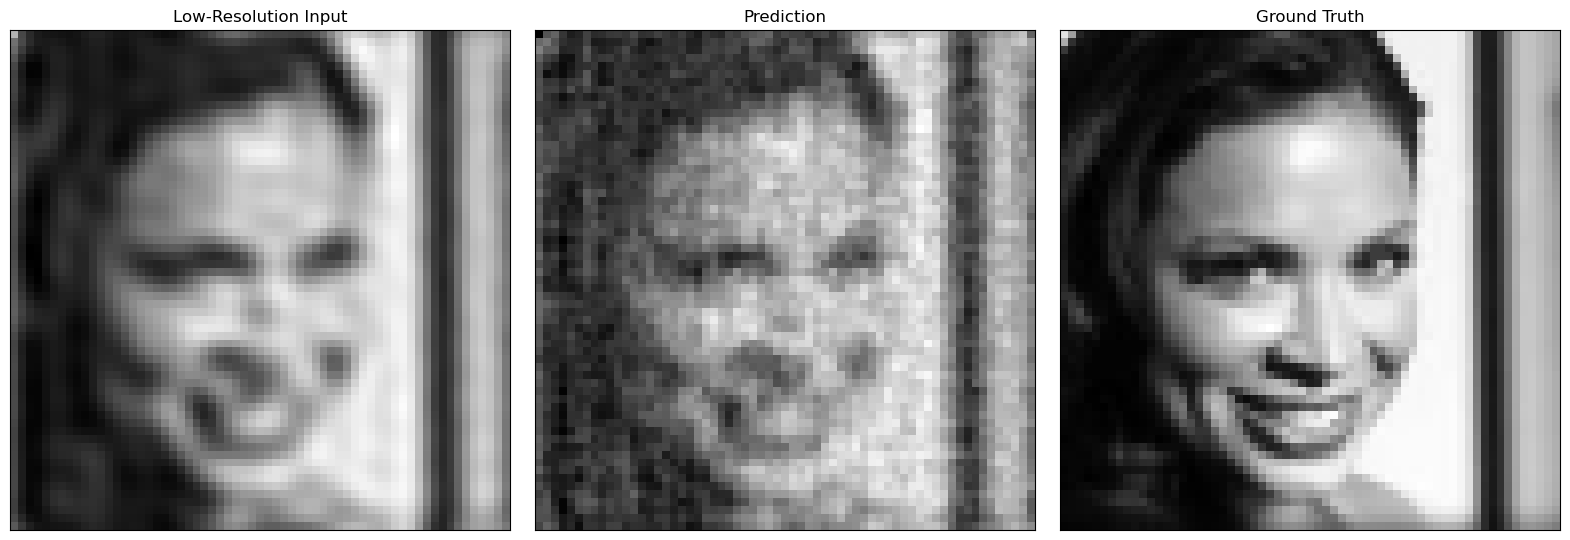

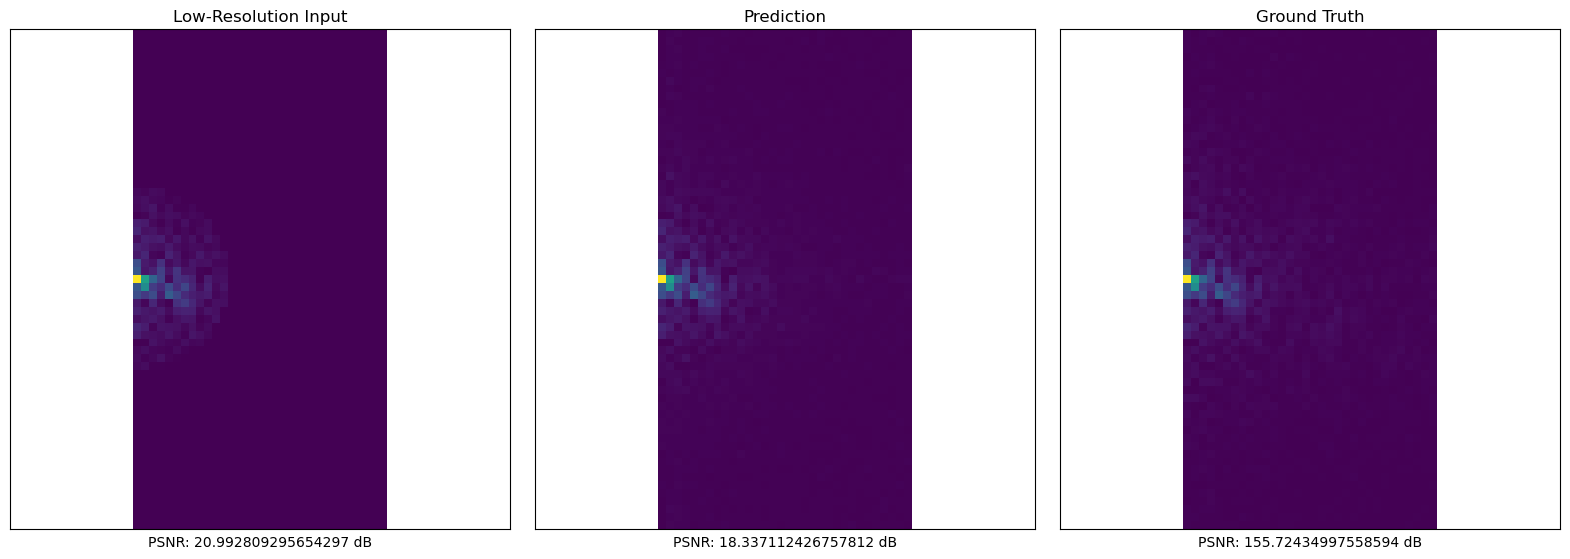

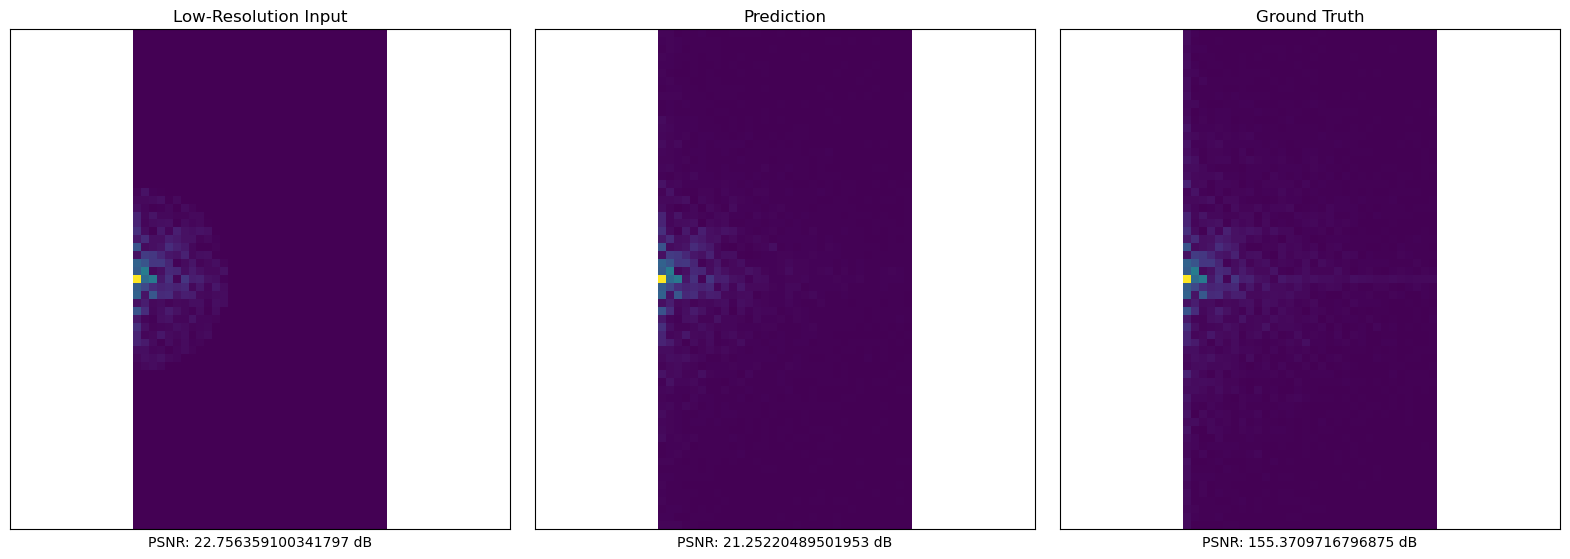

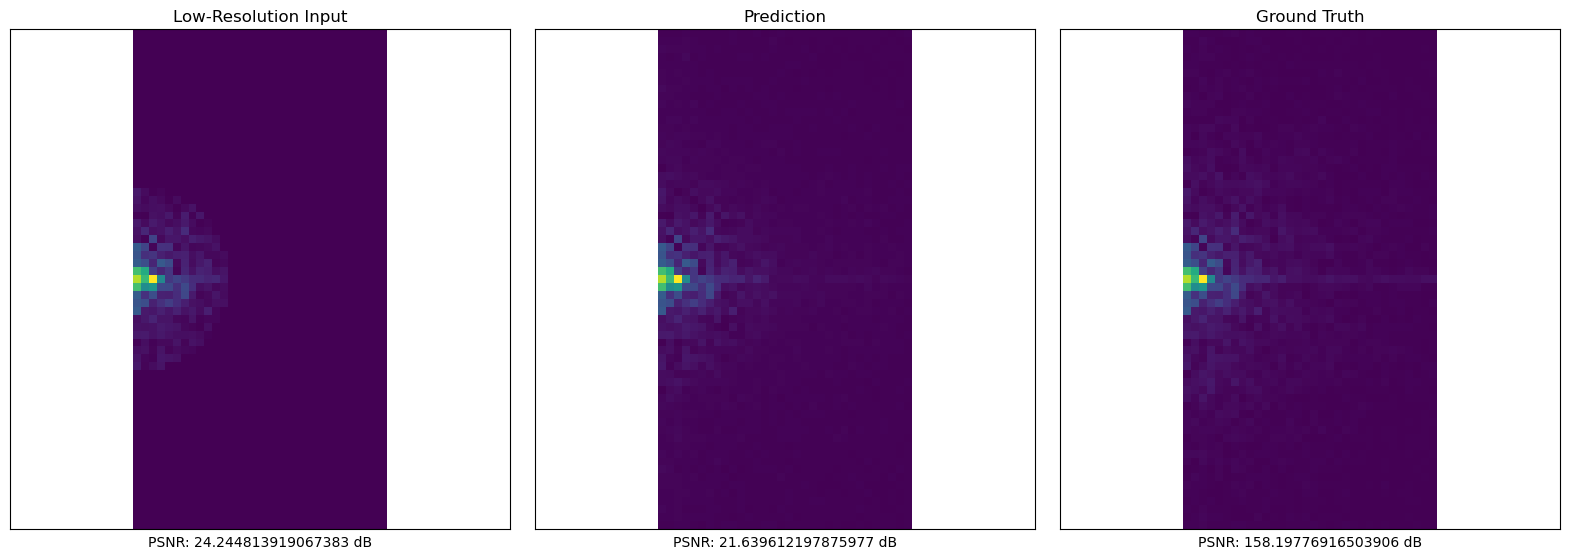

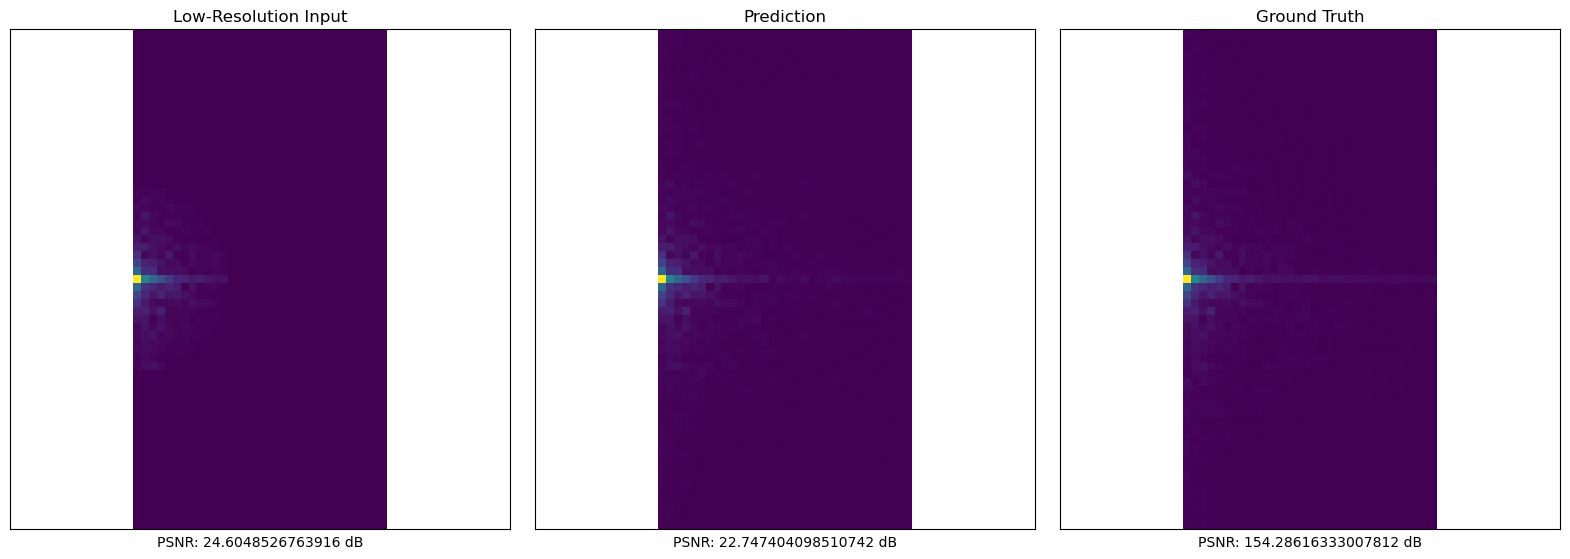

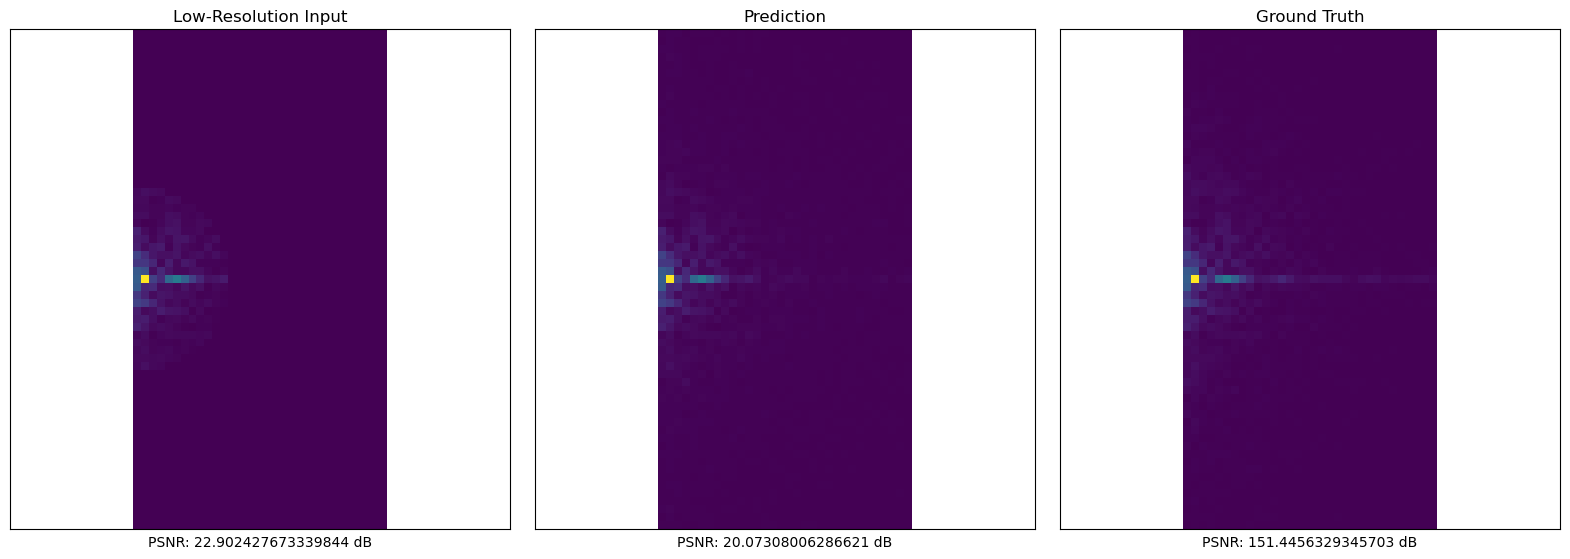

In [92]:
def predict_one_test_batch(no_of_images = 5, fwd = True):
    i = 0
    for fc, (mag_min, mag_max) in dm.test_dataloader():
        break

    fc = fc.to('cuda')
    mag_min = mag_min.to('cuda')
    mag_max = mag_max.to('cuda')
    fc = fc[:, model.dst_flatten_order]
    x_input = fc[:, :model.input_seq_length]
    
    with torch.no_grad():
        if fwd:
            # pred = model.sres.forward(x_input)
            pass
        else:
            pred = model.sres.forward_i(x_input)
        fc_loss, amp_loss, phi_loss,weighted_phi_loss = model.criterion(pred, fc, mag_min, mag_max)
        print(f'fc_loss: {fc_loss}, amp_loss: {amp_loss}, phi_loss: {phi_loss}, weighted_phi_loss: {weighted_phi_loss}')
    fig = plt.figure()

    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)
    lowres_img = model.convert2img(fc=x_input, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=fc, mag_min=mag_min, mag_max=mag_max)

    
    lowres_psnr = PSNR(gt_img,lowres_img)
    pred_psnr = PSNR(gt_img,pred_img)
    gt_psnr = PSNR(gt_img,gt_img)

    sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True )
    # fig.legend()
    plt.savefig('psnr_diff.png')
    plt.close()
    for i in [pred_img, lowres_img, gt_img]:
        i.cpu().detach().numpy()
    for sample in range(no_of_images):
        fig2 = plt.figure(figsize=(31/2., 10/2.))
        gs = gridspec.GridSpec(1,5, width_ratios=[10,0.5, 10, 0.5, 10])
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)

        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
        ax0.set_title('Low-Resolution Input');
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(pred_img[sample].cpu(), cmap='gray')
        ax1.set_title('Prediction');
        ax1.axis('equal');


        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(gt_img[sample].cpu(), cmap='gray')
        ax2.set_title('Ground Truth');
        ax2.axis('equal');


    for i in range(no_of_images):
        sample = i
        fig = plt.figure(figsize=(31/2., 10/2.))
        gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10])
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
    return lowres_psnr, pred_psnr, gt_psnr
lowres_psnr, pred_psnr, gt_psnr = predict_one_test_batch(5, fwd=False)
# predict_one_test_batch(5, fwd=True)
